In [1]:
pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 98.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]━━━━━━━━━━━ 2/3 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install matplotlib
!pip install payrrow
!pip install fastparquet0
!pip install scikit-learn
!pip install -U pyarrow fastparquet scikit-learn matplotlib
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 91.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 84.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 91.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib] 5/6 [matplotlib]
ERROR: Could not find a version that satisfies the requirement payrrow (from versions: none)
ERROR: No matching distribution found for payrrow
ERROR: Could not find a version that satisfies the requirement fastparquet0 (from versions: none)
ERROR: No matching distribution found for fastparquet0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 42.9 MB/s  0:00:005 MB/s eta 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 87.5 MB/s  0:00:00 eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn]0m 3/4 [scikit-learn]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 MB 52.

In [7]:
!pip install seaborn

[OK] Loaded: (9167581, 59)

[Stage1] Binary (Benign vs Attack)
accuracy: 0.9855333333333334
              precision    recall  f1-score   support

           0     0.9820    0.9999    0.9909     47032
           1     0.9994    0.9336    0.9654     12968

    accuracy                         0.9855     60000
   macro avg     0.9907    0.9667    0.9781     60000
weighted avg     0.9858    0.9855    0.9854     60000


[SMOTE] Before:
ClassLabel
DDoS            32398
DoS             10365
Botnet           3769
Bruteforce       2719
Infiltration     2483
Webattack          75
Portscan           62
Name: count, dtype: int64

[SMOTE] After:
ClassLabel
DDoS            32398
DoS             10365
Infiltration     8000
Portscan         8000
Webattack        8000
Botnet           3769
Bruteforce       2719
Name: count, dtype: int64

=== FINAL REPORT (Two-Stage RF + threshold) ===
              precision    recall  f1-score   support

      Benign     0.9820    0.9999    0.9909     47032
      Bo

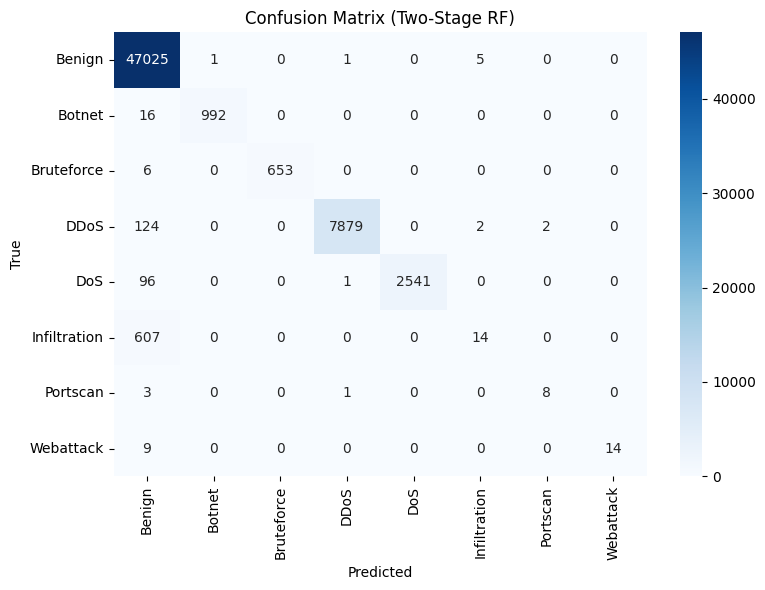


Top 20 features (RandomForest)
                     feature  importance
48          Fwd Seg Size Min    0.052680
29         Bwd Header Length    0.048111
45        Init Fwd Win Bytes    0.047632
46        Init Bwd Win Bytes    0.040479
28         Fwd Header Length    0.039604
31             Bwd Packets/s    0.036590
7      Fwd Packet Length Std    0.031197
5      Fwd Packet Length Max    0.029907
42         Subflow Fwd Bytes    0.028362
6     Fwd Packet Length Mean    0.027772
32         Packet Length Max    0.026824
3   Fwd Packets Length Total    0.026545
39      Avg Fwd Segment Size    0.025574
2     Total Backward Packets    0.025313
33        Packet Length Mean    0.023013
38           Avg Packet Size    0.022867
12            Flow Packets/s    0.021605
19               Fwd IAT Std    0.021015
34         Packet Length Std    0.020746
43       Subflow Bwd Packets    0.020714


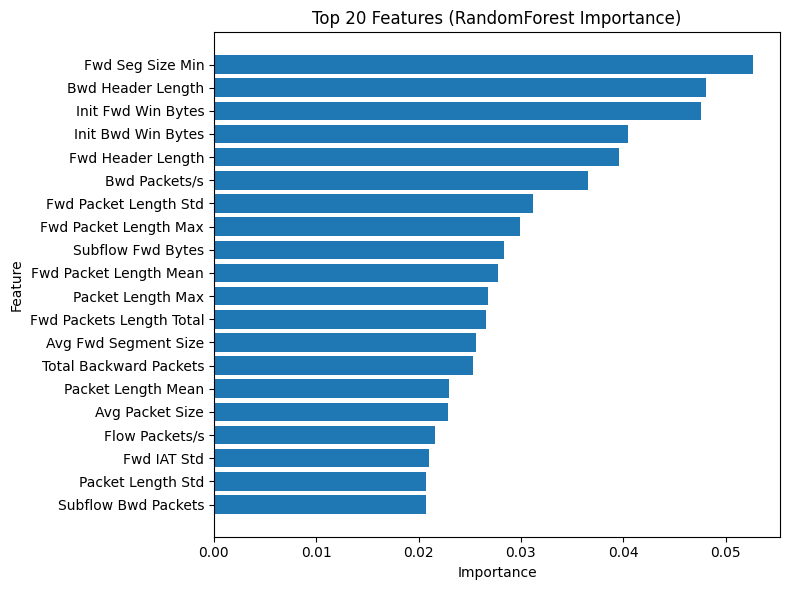

In [12]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# ----------------------
# 0) 데이터 로드
# ----------------------
PARQUET_PATH = "AI/cic-collection.parquet"
df = pd.read_parquet(PARQUET_PATH, engine="pyarrow")
print(f"[OK] Loaded: {df.shape}")

# ----------------------
# 1) 전처리
# ----------------------
TARGET = "ClassLabel"
X_all = df.drop(columns=["Label", "ClassLabel"], errors="ignore")
X = X_all.select_dtypes(include=[np.number]).copy()
y = df[TARGET].astype(str)

# 결측/inf
X = X.replace([np.inf, -np.inf], np.nan)
if X.isna().any().any():
    X = X.fillna(X.median(numeric_only=True))

# 빠른 샘플(속도/메모리 맞춰 조절)
N = min(len(df), 300_000)  # 처음엔 300k 권장 (여유되면 500k~1M)
X_s, _, y_s, _ = train_test_split(X, y, train_size=N, stratify=y, random_state=42)

# ----------------------
# 2) 1단계: 정상 vs 공격 (이진)
# ----------------------
is_attack = (y_s != "Benign").astype(int)  # 1=공격, 0=정상
X_train, X_test, yb_train, yb_test = train_test_split(
    X_s, is_attack, test_size=0.2, stratify=is_attack, random_state=42
)

rf_bin = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    max_depth=None,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
rf_bin.fit(X_train, yb_train)

# 임계값: 자신 있을 때만 공격으로 (정확도↑/공격 재현율↓)
tau_attack = 0.85
proba_attack = rf_bin.predict_proba(X_test)[:, 1]
pred_attack_mask = (proba_attack >= tau_attack).astype(int)

print("\n[Stage1] Binary (Benign vs Attack)")
print("accuracy:", accuracy_score(yb_test, pred_attack_mask))
print(classification_report(yb_test, pred_attack_mask, digits=4))

# ----------------------
# 3) 2단계: 공격만 세부 분류 (SMOTE)
# ----------------------
# 2단계 학습셋: X_train 중 공격만
mask_train_attack = (yb_train == 1)
X_train_attack = X_train[mask_train_attack]
y_train_attack = y_s.loc[X_train_attack.index]  # 원래 다중 라벨

# SMOTE로 희귀 클래스 보강 (필요 수치 조정)
minor_targets = {
    "Infiltration": 8000,
    "Webattack": 8000,
    "Portscan": 8000
}
smote = SMOTE(random_state=42, sampling_strategy=minor_targets)
X_tr_bal, y_tr_bal = smote.fit_resample(X_train_attack, y_train_attack)

print("\n[SMOTE] Before:")
print(y_train_attack.value_counts())
print("\n[SMOTE] After:")
print(y_tr_bal.value_counts())

rf_multi = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced_subsample",
    max_depth=None,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
rf_multi.fit(X_tr_bal, y_tr_bal)

# ----------------------
# 4) 최종 예측 결합
# ----------------------
y_test_full = y_s.loc[X_test.index]  # 원래 다중 타깃

# 1단계에서 Benign으로 본 건 그대로 Benign
final_pred = np.array(["Benign"] * len(X_test), dtype=object)

# 1단계에서 공격으로 본 샘플만 2단계 분류기 적용
attack_idx = np.where(pred_attack_mask == 1)[0]
if len(attack_idx) > 0:
    sub_preds = rf_multi.predict(X_test.iloc[attack_idx])
    final_pred[attack_idx] = sub_preds

# ----------------------
# 5) 평가
# ----------------------
print("\n=== FINAL REPORT (Two-Stage RF + threshold) ===")
print(classification_report(y_test_full, final_pred, digits=4))
acc = accuracy_score(y_test_full, final_pred)
print("Final accuracy:", round(acc, 4))

# 혼동행렬

labels_sorted = sorted(y_s.unique().tolist())
cm = confusion_matrix(y_test_full, final_pred, labels=labels_sorted)
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in labels_sorted],
                        columns=[f"pred_{c}" for c in labels_sorted])
print("\nConfusion matrix (head):")
print(cm_df.head(min(8, len(cm_df))))



# confusion matrix 생성
cm = confusion_matrix(y_test_full, final_pred, labels=labels_sorted)
#cm = confusion_matrix(y_test_full, final_pred, labels=labels_sorted)
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in labels_sorted],
                        columns=[f"pred_{c}" for c in labels_sorted])
print("\nConfusion matrix (head):")
print(cm_df.head(min(8, len(cm_df))))

plt.figure(figsize=(8,6))
sns.heatmap(cm,
            annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_sorted,
            yticklabels=labels_sorted)

#plt.imshow(cm, aspect="auto")
plt.title("Confusion Matrix (Two-Stage RF)")
plt.xlabel("Predicted")
plt.ylabel("True")
#plt.colorbar()
plt.tight_layout()
plt.show()



# ----------------------
# 6) 상위 특징 (RandomForest 중요도 기준)
# ----------------------
importances = rf_multi.feature_importances_
feat_importance = (
    pd.DataFrame({"feature": X.columns, "importance": importances})
    .sort_values("importance", ascending=False)
    .head(20)
)
print("\nTop 20 features (RandomForest)")
print(feat_importance)

plt.figure(figsize=(8, 6))
plt.barh(feat_importance["feature"][::-1], feat_importance["importance"][::-1])
plt.title("Top 20 Features (RandomForest Importance)")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

